In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym import spaces

In [271]:
class Inventory_backlogging(gym.Env):
    def __init__(self, arr_rate, proc_rate1, proc_rate2, queue_cap, max_n_events=10000, inf_reward=-999999):
        super(Inventory_backlogging, self).__init__()
        self.arr_rate = arr_rate
        self.proc_rate1 = proc_rate1
        self.proc_rate2 = proc_rate2
        self.queue_cap = queue_cap
        self.max_n_events = max_n_events
        self.inf_reward = inf_reward

        # initialization
        self.state = np.array([0, 0, 0])

        # actions
        self.actions = [0, 1, 2, 3]
        self.n_actions = len(self.actions)
        self.action_space = spaces.Discrete(self.n_actions)
        self.observation_space = spaces.MultiDiscrete((self.queue_cap + 1, 2, 2))

        self.events = 0

    @property
    def tot_prob(self):
        return self.arr_rate + self.proc_rate1 + self.proc_rate2

    def get_possible_actions(self):
        possible_actions = []
        if not(self.state[0] > 0 and sum(self.state[1:]) == 0):
            possible_actions.append(0)
        if self.state[1] == 0 and self.state[0] >= 1:
            possible_actions.append(1)
        if self.state[2] == 0 and self.state[0] >= 1:
            possible_actions.append(2)
        if self.state[1] == 0 and self.state[2] == 0 and self.state[0] >= 2:
            possible_actions.append(3)
        return possible_actions

    def reset(self):
        self.state = np.array([0, 0, 0])
        self.events = 0
        return self.state.astype(np.float32)

    def action_transition(self, action):
        if action not in self.get_possible_actions():
            return self.inf_reward
        # print("action_transition")
        # print(self.state, action, self.get_possible_actions())
        if action == 1:
            self.state[0] -= 1
            self.state[1] += 1
        if action == 2:
            self.state[0] -= 1
            self.state[2] += 1
        if action == 3:
            self.state[0] -= 2
            self.state[1] += 1
            self.state[2] += 1

        # print(self.state)
        # print("****")
        # return - (10 * self.state[0] + self.state[1] + self.state[2])
        # return - (self.state[0] + 2 * self.state[1] + 2 * self.state[2])
        return - (sum(self.state) * (sum(self.state) + 1) / 2)

    def event_transition(self):
        # print("event_transition")
        next_event = np.random.choice([0, 1, 2], p=[self.arr_rate / self.tot_prob, self.proc_rate1 / self.tot_prob,
                                                    self.proc_rate2 / self.tot_prob])
        # print(next_event)
        if next_event == 0:  # Arrival
            self.state[0] = min(self.state[0] + 1, self.queue_cap)
        elif next_event == 1:  # Service 1 finishes
            self.state[1] = max(0, self.state[1] - 1)
        elif next_event == 2:  # Service 2 finishe
            self.state[2] = max(0, self.state[2] - 1)
        # print(self.state)
        # print("****")

    def step(self, action):
        self.events += 1

        original_state = self.state
        reward = self.action_transition(action)
        state_after_action = self.state

        self.event_transition()
        state_after_event = self.state

        done = self.events >= self.max_n_events

        info = {
            "state_1": original_state[0], 
            "action": action, 
            "state_2": state_after_action[0],
            "reward": reward,
            "state_3": state_after_event[0]
        }

        return self.state.astype(np.float32), reward, done, info

    def render(self, mode='console'):
        if mode != 'console':
            raise NotImplementedError()
        # print(self.state)

    def close(self):
        pass

In [123]:
from stable_baselines3 import DQN, A2C  # KTR
from stable_baselines3.common.cmd_util import make_vec_env

# Instantiate the env
env = Inventory_backlogging(arr_rate=1, proc_rate1=1.8, proc_rate2=0.7, queue_cap=100)
# wrap it
# env = make_vec_env(lambda: env, n_envs=1)

In [124]:
# Train the agent
model = A2C('MlpPolicy', env, verbose=1).learn(300000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| time/                 |           |
|    fps                | 710       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.37     |
|    explained_variance | -2.03e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -1.68e+06 |
|    value_loss         | 1.55e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 651       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -1.27     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007

In [125]:
# Test the trained agent
obs = env.reset()
n_steps = 10000
rewards = 0

all_actions = []

queue_lengths = []
server_1 = []
server_2 = []

queue_lengths_before = []
server_1_before = []
server_2_before = []


for step in range(n_steps):
    action, _ = model.predict(obs) #, deterministic=True)

    queue_lengths_before.append(obs[0])
    server_1_before.append(obs[1])
    server_2_before.append(obs[2])
    
    obs, reward, done, info = env.step(action)

    all_actions.append(action)
    queue_lengths.append(obs[0])
    server_1.append(obs[1])
    server_2.append(obs[2])

    rewards += reward

    if done:
        # Note that the VecEnv resets automatically
        # when a done signal is encountered
        print("Goal reached!", "reward=", reward)
        break

Goal reached! reward= -0.0


## Approach 2

In [288]:
env_2 = Inventory_backlogging(arr_rate=1.8, proc_rate1=2, proc_rate2=0.7, queue_cap=150)
model_2 = A2C('MlpPolicy', env, verbose=1).learn(600000)

In [273]:
# Test the trained agent
obs = env_2.reset()
n_steps = 10000
rewards = 0

all_actions_2 = []

queue_lengths_2 = []
server_1_2 = []
server_2_2 = []

queue_lengths_before_2 = []
server_1_before_2 = []
server_2_before_2 = []


for step in range(n_steps):
    action, _ = model_2.predict(obs) #, deterministic=True)

    queue_lengths_before_2.append(obs[0])
    server_1_before_2.append(obs[1])
    server_2_before_2.append(obs[2])
    
    obs, reward, done, info = env_2.step(action)

    all_actions_2.append(action)
    queue_lengths_2.append(obs[0])
    server_1_2.append(obs[1])
    server_2_2.append(obs[2])

    rewards += reward

    if done:
        # Note that the VecEnv resets automatically
        # when a done signal is encountered
        print("Goal reached!", "reward=", reward)
        break

Goal reached! reward= -136.0


## Approach 3

In [294]:
env_3 = Inventory_backlogging(arr_rate=2.3, proc_rate1=2, proc_rate2=0.7, queue_cap=150)
model_3 = A2C('MlpPolicy', env, verbose=1).learn(600000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| time/                 |           |
|    fps                | 446       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.36     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -1.99e+06 |
|    value_loss         | 2.93e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 443      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.11    |
|    explained_variance | -0.0169  |
|    learning_rate      | 0.0007   |
|   

In [317]:
# Test the trained agent
obs = env_3.reset()
n_steps = 10000
rewards = 0

all_actions_3 = []

queue_lengths_3 = []
server_1_3 = []
server_2_3 = []

queue_lengths_before_3 = []
server_1_before_3 = []
server_2_before_3 = []


for step in range(n_steps):
    action, _ = model_3.predict(obs) #, deterministic=True)

    queue_lengths_before_3.append(obs[0])
    server_1_before_3.append(obs[1])
    server_2_before_3.append(obs[2])
    
    obs, reward, done, info = env_3.step(action)

    all_actions_3.append(action)
    queue_lengths_3.append(obs[0])
    server_1_3.append(obs[1])
    server_2_3.append(obs[2])

    rewards += reward

    if done:
        # Note that the VecEnv resets automatically
        # when a done signal is encountered
        print("Goal reached!", "reward=", reward)
        break

Goal reached! reward= -3.0


In [318]:
rewards / n_steps

-10651.6392

In [319]:
sum(a == 0 for a in all_actions)

7285

In [320]:
print(np.mean([q for a, q in zip(all_actions, queue_lengths) if a == 1]))
print(np.mean([q for a, q in zip(all_actions, queue_lengths) if a == 2]))

0.5008285
1.17


# Hopeful approach

In [391]:
import itertools
import pandas as pd
queue_cap = 150

In [378]:
model_3.predict(all_states[17], deterministic=True)

(1, None)

In [387]:
queue_cap

150

In [418]:
all_states = [np.array(list(s), dtype="int64").reshape(3, ) for s in itertools.product(range(100 + 1), range(2), range(2))]
opt_policies = []
for s in all_states:
    opt_policies.append(list(s) + [model_3.predict(s)[0]])

In [419]:
opt_df = pd.DataFrame(opt_policies, columns=["s0", "s1", "s2", "policy"])

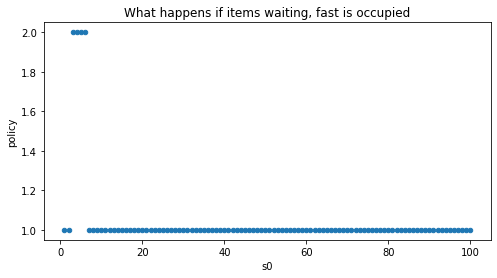

In [427]:
sel_df = opt_df.loc[(opt_df.s0 > 0) & (opt_df.s1 == 0) & (opt_df.s2 == 0)]
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("What happens if items waiting, fast is occupied")
sel_df.plot(x="s0", y="policy", kind="scatter", ax=ax);

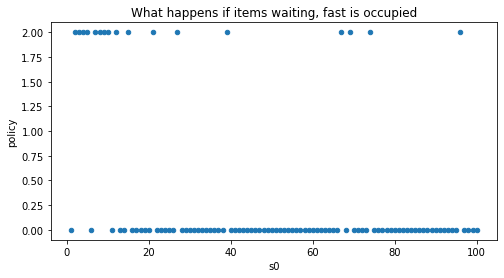

In [426]:
sel_df = opt_df.loc[(opt_df.s0 > 0) & (opt_df.s1 == 1) & (opt_df.s2 == 0)]
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("What happens if items waiting, fast is occupied")
sel_df.plot(x="s0", y="policy", kind="scatter", ax=ax);

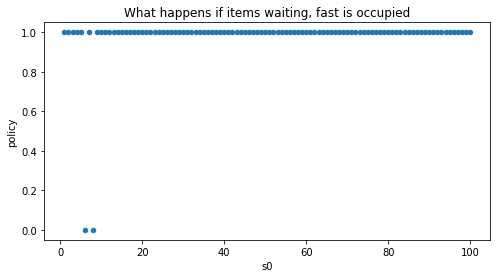

In [424]:
sel_df = opt_df.loc[(opt_df.s0 > 0) & (opt_df.s1 == 0) & (opt_df.s2 == 1)]
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("What happens if items waiting, fast is occupied")
sel_df.plot(x="s0", y="policy", kind="scatter", ax=ax);

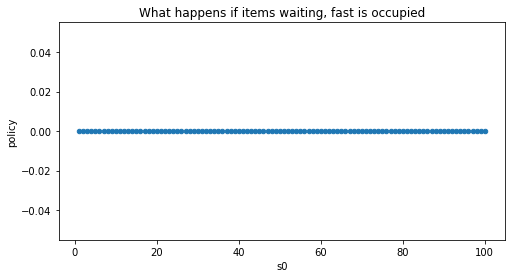

In [425]:
sel_df = opt_df.loc[(opt_df.s0 > 0) & (opt_df.s1 == 1) & (opt_df.s2 == 1)]
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("What happens if items waiting, fast is occupied")
sel_df.plot(x="s0", y="policy", kind="scatter", ax=ax);

# $\lambda= 2.3$, $\mu_1= 2$, $\mu_2= 0.7$, Queue Capacity= 150

In [321]:
action_played_0_case_00 = []
action_played_0_case_01 = []
action_played_0_case_10 = []
action_played_0_case_11 = []

action_played_1_case_00 = []
action_played_1_case_01 = []
action_played_1_case_10 = []
action_played_1_case_11 = []

action_played_2_case_00 = []
action_played_2_case_01 = []
action_played_2_case_10 = []
action_played_2_case_11 = []

action_played_3_case_00 = []
action_played_3_case_01 = []
action_played_3_case_10 = []
action_played_3_case_11 = []


for a, q, s1, s2, qb, s1b, s2b in zip(
    all_actions_3, queue_lengths_3, server_1_3, server_2_3, queue_lengths_before_3, server_1_before_3, server_2_before_3
):
    # print((int(qb), int(s1b), int(s2b)), "->", a ,"->", (int(q), int(s1), int(s2)))
    if s1b == 0 and s2b == 0:
        if a == 0:
            action_played_0_case_00.append(qb)
        elif a == 1:
            action_played_1_case_00.append(qb)
        elif a == 2:
            action_played_2_case_00.append(qb)
        elif a == 3:
            action_played_3_case_00.append(qb)
    
    elif s1b == 0 and s2b == 1:
        if a == 0:
            action_played_0_case_01.append(qb)
        elif a == 1:
            action_played_1_case_01.append(qb)
        elif a == 2:
            action_played_2_case_01.append(qb)
        elif a == 3:
            action_played_3_case_01.append(qb)

    elif s1b == 1 and s2b == 0:
        if a == 0:
            action_played_0_case_10.append(qb)
        elif a == 1:
            action_played_1_case_10.append(qb)
        elif a == 2:
            action_played_2_case_10.append(qb)
        elif a == 3:
            action_played_3_case_10.append(qb)

    elif s1b == 1 and s2b == 1:
        if a == 0:
            action_played_0_case_11.append(qb)
        elif a == 1:
            action_played_1_case_11.append(qb)
        elif a == 2:
            action_played_2_case_11.append(qb)
        elif a == 3:
            action_played_3_case_11.append(qb)
    
action_played_0_case_00 = np.array(action_played_0_case_00)
action_played_0_case_01 = np.array(action_played_0_case_01)
action_played_0_case_10 = np.array(action_played_0_case_10)
action_played_0_case_11 = np.array(action_played_0_case_11)
action_played_1_case_00 = np.array(action_played_1_case_00)
action_played_1_case_01 = np.array(action_played_1_case_01)
action_played_1_case_10 = np.array(action_played_1_case_10)
action_played_1_case_11 = np.array(action_played_1_case_11)
action_played_2_case_00 = np.array(action_played_2_case_00)
action_played_2_case_01 = np.array(action_played_2_case_01)
action_played_2_case_10 = np.array(action_played_2_case_10)
action_played_2_case_11 = np.array(action_played_2_case_11)
action_played_3_case_00 = np.array(action_played_3_case_00)
action_played_3_case_01 = np.array(action_played_3_case_01)
action_played_3_case_10 = np.array(action_played_3_case_10)
action_played_3_case_11 = np.array(action_played_3_case_11)

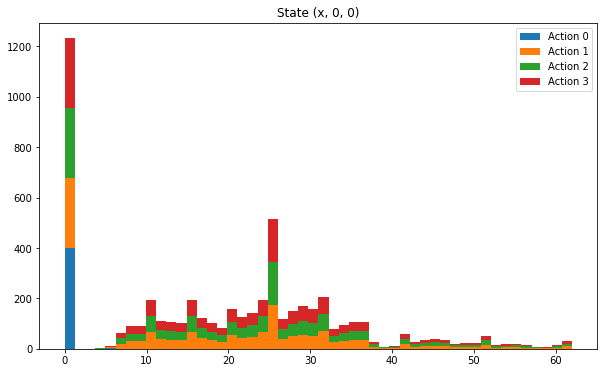

In [339]:
plt.figure(figsize=(10, 6))
plt.hist(
    [action_played_0_case_00, action_played_1_case_00, action_played_1_case_00, action_played_1_case_00], 
    stacked=True,
    bins=50
)
plt.title("State (x, 0, 0)")
plt.legend(["Action 0", "Action 1", "Action 2", "Action 3"]);

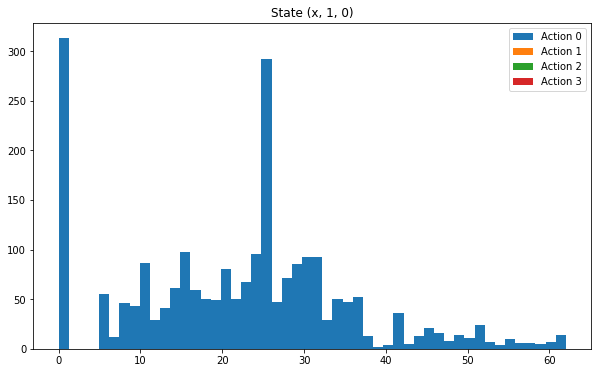

In [340]:
plt.figure(figsize=(10, 6))
plt.hist([action_played_0_case_10, action_played_1_case_10, action_played_1_case_10, action_played_1_case_10], stacked=True, bins=50)
plt.title("State (x, 1, 0)")
plt.legend(["Action 0", "Action 1", "Action 2", "Action 3"]);

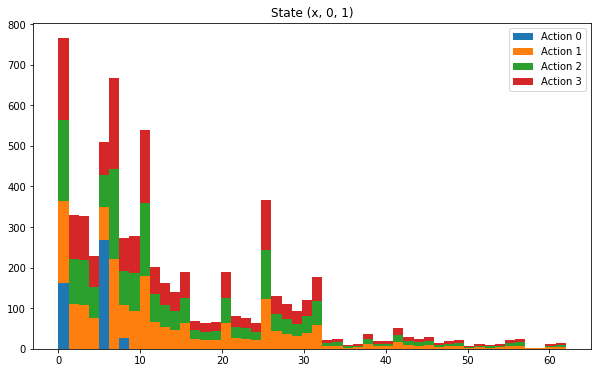

In [341]:
plt.figure(figsize=(10, 6))
plt.hist([action_played_0_case_01, action_played_1_case_01, action_played_1_case_01, action_played_1_case_01], stacked=True, bins=50)
plt.title("State (x, 0, 1)")
plt.legend(["Action 0", "Action 1", "Action 2", "Action 3"]);

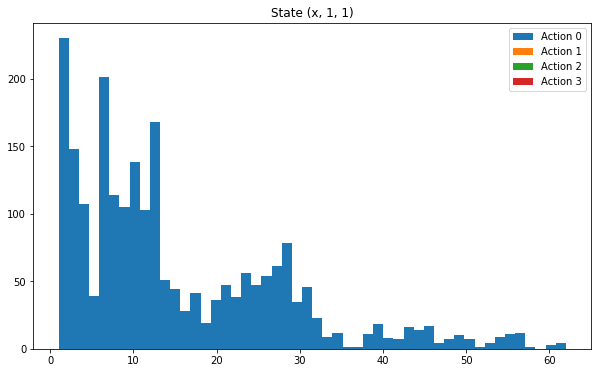

In [342]:
plt.figure(figsize=(10, 6))
plt.hist([action_played_0_case_11, action_played_1_case_11, action_played_1_case_11, action_played_1_case_11], stacked=True, bins=50)
plt.title("State (x, 1, 1)")
plt.legend(["Action 0", "Action 1", "Action 2", "Action 3"]);

# $\lambda= 1.8$, $\mu_1= 2$, $\mu_2= 0.7$, Queue Capacity= 150

In [295]:
action_played_0_case_00 = []
action_played_0_case_01 = []
action_played_0_case_10 = []
action_played_0_case_11 = []

action_played_1_case_00 = []
action_played_1_case_01 = []
action_played_1_case_10 = []
action_played_1_case_11 = []

action_played_2_case_00 = []
action_played_2_case_01 = []
action_played_2_case_10 = []
action_played_2_case_11 = []

action_played_3_case_00 = []
action_played_3_case_01 = []
action_played_3_case_10 = []
action_played_3_case_11 = []


for a, q, s1, s2, qb, s1b, s2b in zip(
    all_actions_2, queue_lengths_2, server_1_2, server_2_2, queue_lengths_before_2, server_1_before_2, server_2_before_2
):
    # print((int(qb), int(s1b), int(s2b)), "->", a ,"->", (int(q), int(s1), int(s2)))
    if s1b == 0 and s2b == 0:
        if a == 0:
            action_played_0_case_00.append(qb)
        elif a == 1:
            action_played_1_case_00.append(qb)
        elif a == 2:
            action_played_2_case_00.append(qb)
        elif a == 3:
            action_played_3_case_00.append(qb)
    
    elif s1b == 0 and s2b == 1:
        if a == 0:
            action_played_0_case_01.append(qb)
        elif a == 1:
            action_played_1_case_01.append(qb)
        elif a == 2:
            action_played_2_case_01.append(qb)
        elif a == 3:
            action_played_3_case_01.append(qb)

    elif s1b == 1 and s2b == 0:
        if a == 0:
            action_played_0_case_10.append(qb)
        elif a == 1:
            action_played_1_case_10.append(qb)
        elif a == 2:
            action_played_2_case_10.append(qb)
        elif a == 3:
            action_played_3_case_10.append(qb)

    elif s1b == 1 and s2b == 1:
        if a == 0:
            action_played_0_case_11.append(qb)
        elif a == 1:
            action_played_1_case_11.append(qb)
        elif a == 2:
            action_played_2_case_11.append(qb)
        elif a == 3:
            action_played_3_case_11.append(qb)
    
action_played_0_case_00 = np.array(action_played_0_case_00)
action_played_0_case_01 = np.array(action_played_0_case_01)
action_played_0_case_10 = np.array(action_played_0_case_10)
action_played_0_case_11 = np.array(action_played_0_case_11)
action_played_1_case_00 = np.array(action_played_1_case_00)
action_played_1_case_01 = np.array(action_played_1_case_01)
action_played_1_case_10 = np.array(action_played_1_case_10)
action_played_1_case_11 = np.array(action_played_1_case_11)
action_played_2_case_00 = np.array(action_played_2_case_00)
action_played_2_case_01 = np.array(action_played_2_case_01)
action_played_2_case_10 = np.array(action_played_2_case_10)
action_played_2_case_11 = np.array(action_played_2_case_11)
action_played_3_case_00 = np.array(action_played_3_case_00)
action_played_3_case_01 = np.array(action_played_3_case_01)
action_played_3_case_10 = np.array(action_played_3_case_10)
action_played_3_case_11 = np.array(action_played_3_case_11)

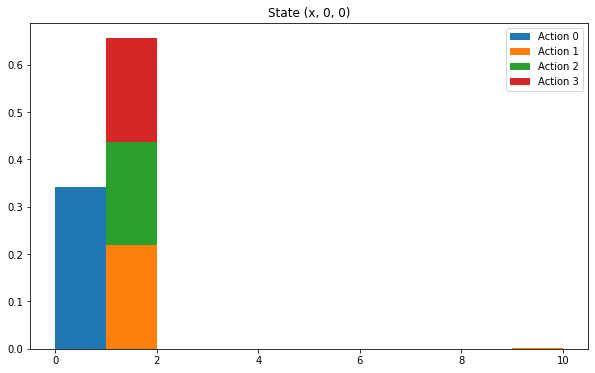

In [296]:
plt.figure(figsize=(10, 6))
plt.hist(
    [action_played_0_case_00, action_played_1_case_00, action_played_1_case_00, action_played_1_case_00], 
    density=True, 
    stacked=True
)
plt.title("State (x, 0, 0)")
plt.legend(["Action 0", "Action 1", "Action 2", "Action 3"]);

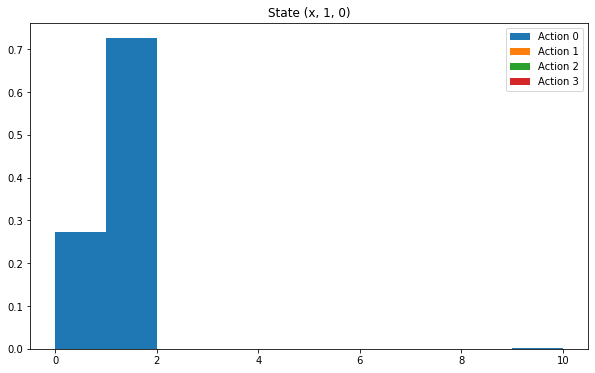

In [297]:
plt.figure(figsize=(10, 6))
plt.hist([action_played_0_case_10, action_played_1_case_10, action_played_1_case_10, action_played_1_case_10], density=True, stacked=True)
plt.title("State (x, 1, 0)")
plt.legend(["Action 0", "Action 1", "Action 2", "Action 3"]);

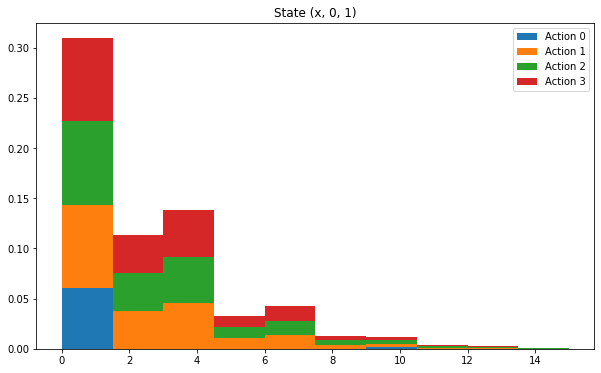

In [298]:
plt.figure(figsize=(10, 6))
plt.hist([action_played_0_case_01, action_played_1_case_01, action_played_1_case_01, action_played_1_case_01], density=True, stacked=True)
plt.title("State (x, 0, 1)")
plt.legend(["Action 0", "Action 1", "Action 2", "Action 3"]);

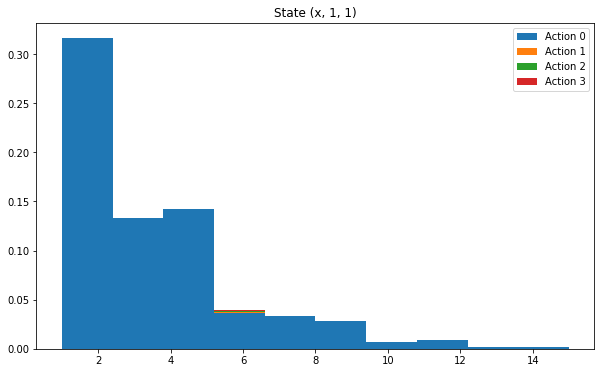

In [299]:
plt.figure(figsize=(10, 6))
plt.hist([action_played_0_case_11, action_played_1_case_11, action_played_1_case_11, action_played_1_case_11], density=True, stacked=True)
plt.title("State (x, 1, 1)")
plt.legend(["Action 0", "Action 1", "Action 2", "Action 3"]);

# $\lambda= 1$, $\mu_1= 1.8$, $\mu_2= 0.7$, Queue Capacity= 100

In [306]:
action_played_0_case_00 = []
action_played_0_case_01 = []
action_played_0_case_10 = []
action_played_0_case_11 = []

action_played_1_case_00 = []
action_played_1_case_01 = []
action_played_1_case_10 = []
action_played_1_case_11 = []

action_played_2_case_00 = []
action_played_2_case_01 = []
action_played_2_case_10 = []
action_played_2_case_11 = []

action_played_3_case_00 = []
action_played_3_case_01 = []
action_played_3_case_10 = []
action_played_3_case_11 = []


for a, q, s1, s2, qb, s1b, s2b in zip(
    all_actions, queue_lengths, server_1, server_2, queue_lengths_before, server_1_before, server_2_before
):
    # print((int(qb), int(s1b), int(s2b)), "->", a ,"->", (int(q), int(s1), int(s2)))
    if s1b == 0 and s2b == 0:
        if a == 0:
            action_played_0_case_00.append(qb)
        elif a == 1:
            action_played_1_case_00.append(qb)
        elif a == 2:
            action_played_2_case_00.append(qb)
        elif a == 3:
            action_played_3_case_00.append(qb)
    
    elif s1b == 0 and s2b == 1:
        if a == 0:
            action_played_0_case_01.append(qb)
        elif a == 1:
            action_played_1_case_01.append(qb)
        elif a == 2:
            action_played_2_case_01.append(qb)
        elif a == 3:
            action_played_3_case_01.append(qb)

    elif s1b == 1 and s2b == 0:
        if a == 0:
            action_played_0_case_10.append(qb)
        elif a == 1:
            action_played_1_case_10.append(qb)
        elif a == 2:
            action_played_2_case_10.append(qb)
        elif a == 3:
            action_played_3_case_10.append(qb)

    elif s1b == 1 and s2b == 1:
        if a == 0:
            action_played_0_case_11.append(qb)
        elif a == 1:
            action_played_1_case_11.append(qb)
        elif a == 2:
            action_played_2_case_11.append(qb)
        elif a == 3:
            action_played_3_case_11.append(qb)
    
action_played_0_case_00 = np.array(action_played_0_case_00)
action_played_0_case_01 = np.array(action_played_0_case_01)
action_played_0_case_10 = np.array(action_played_0_case_10)
action_played_0_case_11 = np.array(action_played_0_case_11)
action_played_1_case_00 = np.array(action_played_1_case_00)
action_played_1_case_01 = np.array(action_played_1_case_01)
action_played_1_case_10 = np.array(action_played_1_case_10)
action_played_1_case_11 = np.array(action_played_1_case_11)
action_played_2_case_00 = np.array(action_played_2_case_00)
action_played_2_case_01 = np.array(action_played_2_case_01)
action_played_2_case_10 = np.array(action_played_2_case_10)
action_played_2_case_11 = np.array(action_played_2_case_11)
action_played_3_case_00 = np.array(action_played_3_case_00)
action_played_3_case_01 = np.array(action_played_3_case_01)
action_played_3_case_10 = np.array(action_played_3_case_10)
action_played_3_case_11 = np.array(action_played_3_case_11)

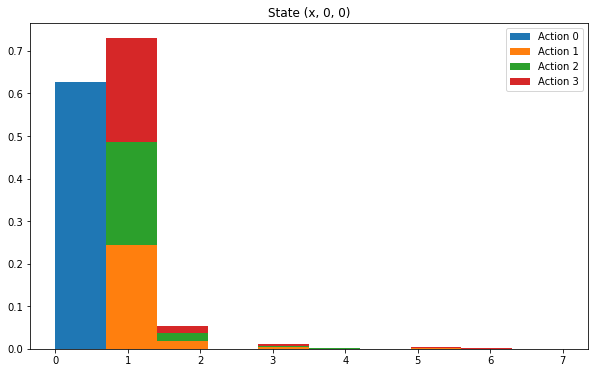

In [307]:
plt.figure(figsize=(10, 6))
plt.hist(
    [action_played_0_case_00, action_played_1_case_00, action_played_1_case_00, action_played_1_case_00], 
    density=True, 
    stacked=True
)
plt.title("State (x, 0, 0)")
plt.legend(["Action 0", "Action 1", "Action 2", "Action 3"]);

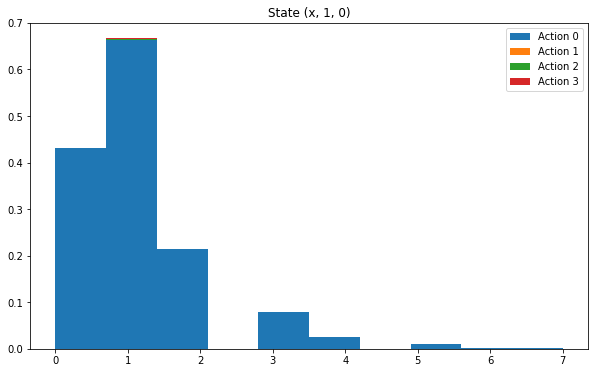

In [308]:
plt.figure(figsize=(10, 6))
plt.hist([action_played_0_case_10, action_played_1_case_10, action_played_1_case_10, action_played_1_case_10], density=True, 
    stacked=True)
plt.title("State (x, 1, 0)")
plt.legend(["Action 0", "Action 1", "Action 2", "Action 3"]);

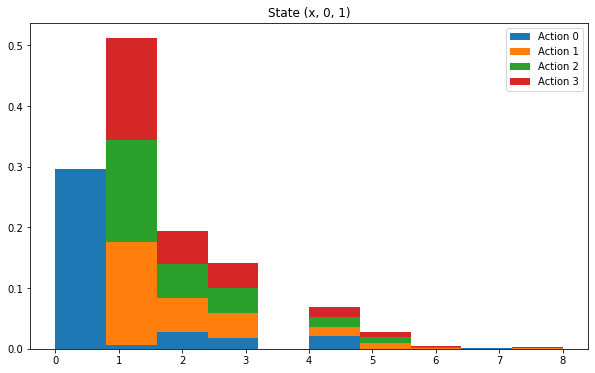

In [309]:
plt.figure(figsize=(10, 6))
plt.hist([action_played_0_case_01, action_played_1_case_01, action_played_1_case_01, action_played_1_case_01], density=True, 
    stacked=True)
plt.title("State (x, 0, 1)")
plt.legend(["Action 0", "Action 1", "Action 2", "Action 3"]);

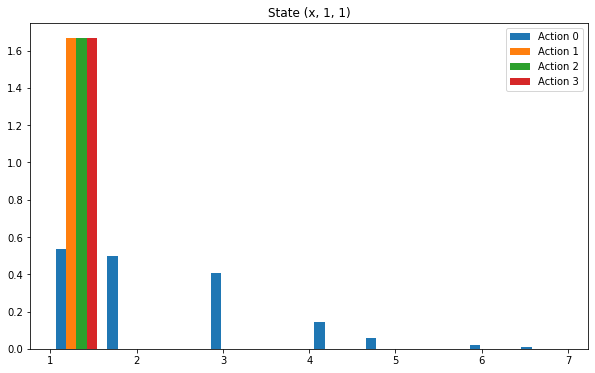

In [315]:
plt.figure(figsize=(10, 6))
plt.hist([action_played_0_case_11, action_played_1_case_11, action_played_1_case_11, action_played_1_case_11], density=True)
plt.title("State (x, 1, 1)")
plt.legend(["Action 0", "Action 1", "Action 2", "Action 3"]);

(array([[ 1.,  0., 10., 12., 31., 29., 12.,  3.,  1.,  1.],
        [ 1.,  1.,  5., 18., 30., 23., 13.,  7.,  1.,  1.],
        [ 1.,  6.,  8., 14., 28., 27., 11.,  4.,  1.,  0.]]),
 array([-3.45820998, -2.73214975, -2.00608951, -1.28002927, -0.55396903,
         0.1720912 ,  0.89815144,  1.62421168,  2.35027191,  3.07633215,
         3.80239239]),
 <a list of 3 BarContainer objects>)

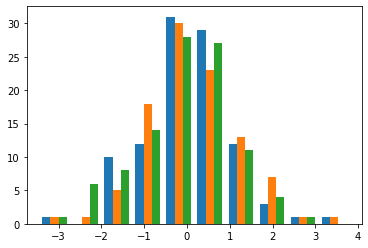

In [183]:
x = np.random.randn(100, 3)
plt.hist(x)

# $\lambda= 1$, $\mu_1= 1.5$, $\mu_2= 0.1$, Queue Capacity= 100

In [108]:
demo0 = []
demo1 = []
demo2 = []
demo3 = []
for a, q, s1, s2, qb, s1b, s2b in zip(
    all_actions, queue_lengths, server_1, server_2, queue_lengths_before, server_1_before, server_2_before
):
    # print((int(qb), int(s1b), int(s2b)), "->", a ,"->", (int(q), int(s1), int(s2)))
    if a == 0:
        demo0.append(int(qb) + int(s1b) + int(s2b))
    if a == 1:
        demo1.append(int(qb) + int(s1b) + int(s2b))
    if a == 2:
        demo2.append(int(qb) + int(s1b) + int(s2b))
    if a == 3:
        demo3.append(int(qb) + int(s1b) + int(s2b))

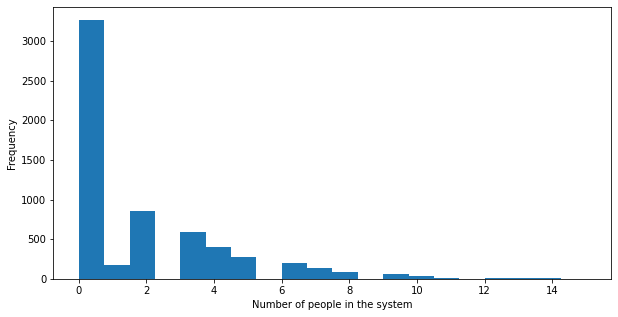

In [112]:
plt.figure(figsize=(10, 5))
plt.hist(demo0, bins=20)
plt.xlabel("Number of people in the system")
plt.ylabel("Frequency");

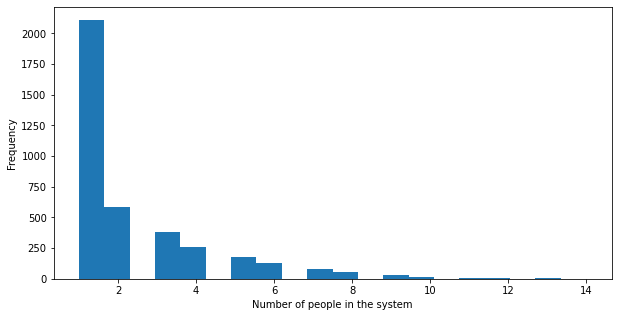

In [113]:
plt.figure(figsize=(10, 5))
plt.hist(demo1, bins=20)
plt.xlabel("Number of people in the system")
plt.ylabel("Frequency");

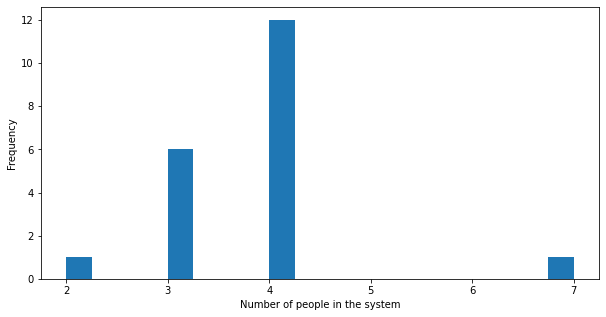

In [114]:
plt.figure(figsize=(10, 5))
plt.hist(demo2, bins=20)
plt.xlabel("Number of people in the system")
plt.ylabel("Frequency");

# $\lambda=1$, $\mu_1=1.5$, $\mu_2=0.5$, Queue Capacity=100

In [162]:
demo0 = []
demo1 = []
demo2 = []
demo3 = []
for a, q, s1, s2, qb, s1b, s2b in zip(
    all_actions, queue_lengths, server_1, server_2, queue_lengths_before, server_1_before, server_2_before
):
    # print((int(qb), int(s1b), int(s2b)), "->", a ,"->", (int(q), int(s1), int(s2)))
    if a == 0:
        demo0.append(int(qb) + int(s1b) + int(s2b))
    if a == 1:
        demo1.append(int(qb) + int(s1b) + int(s2b))
    if a == 2:
        demo2.append(int(qb) + int(s1b) + int(s2b))
    if a == 3:
        demo3.append(int(qb) + int(s1b) + int(s2b))

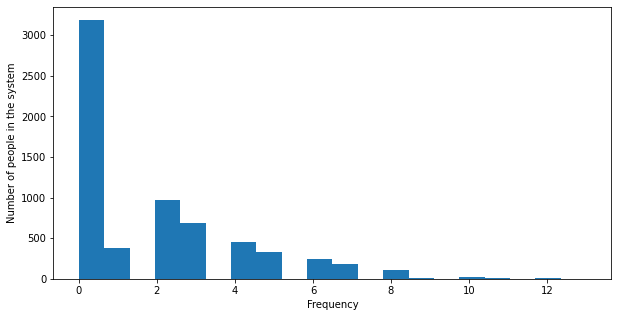

In [199]:
plt.figure(figsize=(10, 5))
plt.hist(demo0, bins=20)
plt.ylabel("Number of people in the system")
plt.xlabel("Frequency");

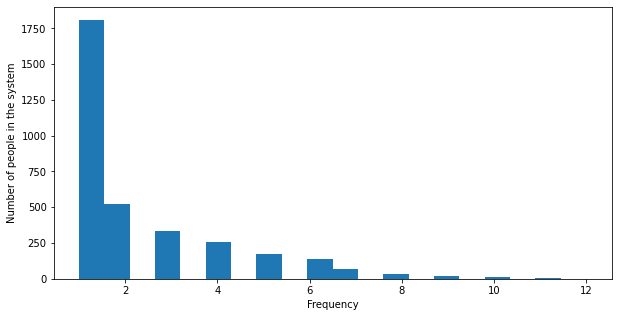

In [198]:
plt.figure(figsize=(10, 5))
plt.hist(demo1, bins=20)
plt.ylabel("Number of people in the system")
plt.xlabel("Frequency");

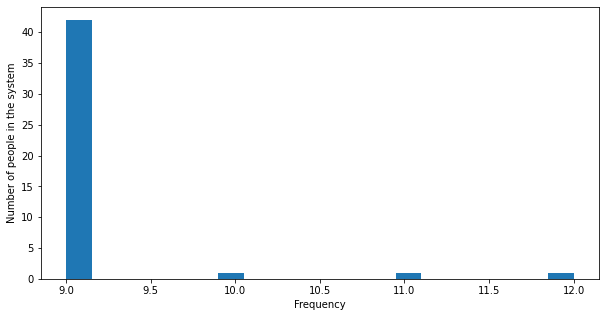

In [197]:
plt.figure(figsize=(10, 5))
plt.hist(demo2, bins=20)
plt.ylabel("Number of people in the system")
plt.xlabel("Frequency");

In [154]:
actions_0, actions_1, actions_2, actions_3 = [], [], [], []
actions_0q, actions_1q, actions_2q, actions_3q = [], [], [], []

for q, s1, s2, a in zip(
    queue_lengths_before, server_1_before, server_2_before, all_actions
):  
    if a == 0:
        actions_0q.append(q)
        actions_0.append(q + s1 + s2)
    if a == 1:
        actions_1q.append(q)
        actions_1.append(q + s1 + s2)
    if a == 2:
        actions_2q.append(q)
        actions_2.append(q + s1 + s2)
    if a == 3:
        actions_3q.append(q)
        actions_3.append(q + s1 + s2)

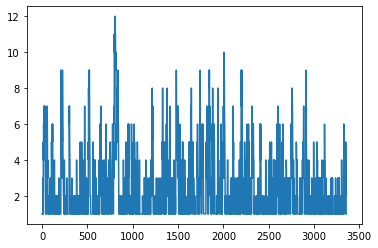

In [161]:
plt.plot(actions_1)